# Bell inequality example - CSHS game (from qiskit docs)
This code is based on an example from the Qiskit docs. This experiment is equivalent to Bell's proposed experiment for testing for Hidden Variables.
https://cds.cern.ch/record/111654/files/vol1p195-200_001.pdf

In [28]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (2) and
                                                         not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [32]:
sim = Aer.get_backend('aer_simulator')

In [33]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)

        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob

        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []

    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a)
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits

In [34]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order of circuits is ZZ,ZX,XZ,XX, they come in fours

    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):
        theta_dict = counts[i:i + 4]
        # Results for all 4 circuits for a specific theta
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        # For every circuit - count
        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)

    return CHSH1, CHSH2

In [84]:
number_of_thetas = 24
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

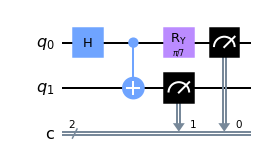

In [68]:
my_chsh_circuits[4].draw('mpl')

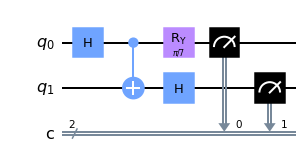

In [69]:
my_chsh_circuits[5].draw('mpl')

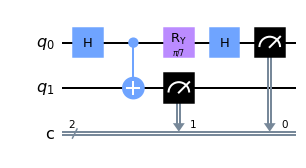

In [70]:
my_chsh_circuits[6].draw('mpl')

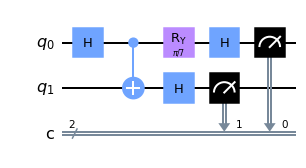

In [71]:
my_chsh_circuits[7].draw('mpl')

In [85]:
# Execute Simulation and get counts
result_ideal = sim.run(my_chsh_circuits).result()

In [86]:
# Execute on real device and get counts
startTime = time.time()
transpiled_circuits = transpile(my_chsh_circuits, backend)
job_real = backend.run(transpiled_circuits, shots=8096)
job_monitor(job_real)
result_real = job_real.result()
endTime = time.time()

print(endTime - startTime)

Job Status: job has successfully run
232.4028480052948


In [87]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

Text(0, 0.5, 'CHSH witness')

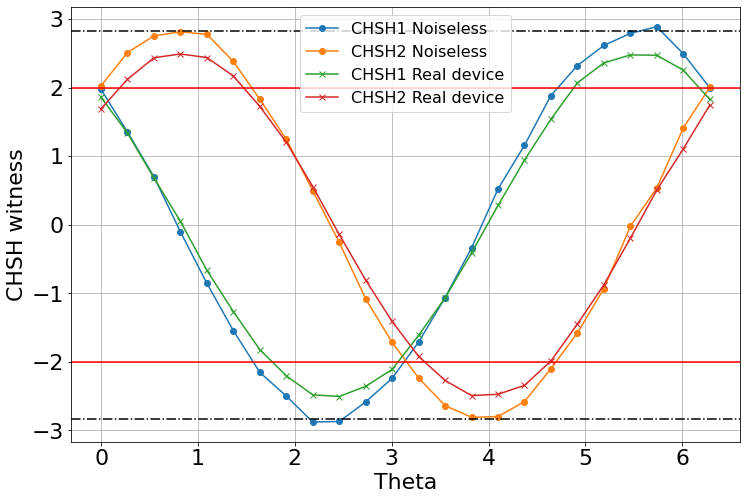

In [88]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Real device')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Real device')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')